### Table of Contents

# 1. Import Data

## 1.1 Import the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from datetime import date

%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

## 1.2 Import a integrate data

In [2]:
df_crm = pd.read_csv('crm.csv')
df_mkt = pd.read_csv('mkt.csv')
df_sales = pd.read_excel('sales.xlsx')

In [3]:
df = pd.merge(pd.merge(df_crm,df_sales,on='CustomerID',how="inner"),df_mkt,on="CustomerID",how="inner")

## 1.3 Set Index


In [4]:
df.set_index('CustomerID',inplace = True)

## 1.4 Check and removing duplicates

In [5]:
df[df.duplicated()] # checking duplicates

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
32924,Mrs. Wanda Terry,1986,Graduation,Divorced,41264.0,1,1,2020-10-03 00:00:00,61.0,70.0,20,165.0,40.0,0.0,7.0,2,3,1,3,7,0,0,0,0,0,0
8276,Mrs. Mary Jackson,1968,HighSchool,Married,118238.0,0,0,2020-10-13 00:00:00,42.0,5940.0,1002,9465.0,1100.0,1100.0,32.0,1,6,7,8,2,0,0,0,0,0,0
32966,Mr. Steven Baker,1961,HighSchool,Married,84974.0,0,1,2022-02-17 00:00:00,56.0,2610.0,840,2160.0,840.0,960.0,133.0,3,6,5,9,3,0,0,0,0,0,0
5627,Mr. Jonathan Clark,1988,Graduation,Married,40975.0,1,0,2022-04-28 00:00:00,31.0,130.0,0,120.0,20.0,20.0,5.0,1,3,1,4,3,0,0,0,0,0,0
29357,Mr. Eric Springer,1972,PhD,Married,77778.0,0,1,2022-04-19 00:00:00,92.0,1240.0,60,315.0,20.0,20.0,33.0,1,5,2,4,6,0,0,1,0,0,0
26891,Mr. Sam Peake,1992,Graduation,Married,74147.0,1,0,2022-03-21 00:00:00,13.0,610.0,320,915.0,20.0,240.0,78.0,2,6,3,2,6,0,1,0,0,0,0
21269,Mr. Nathan Glover,1971,Graduation,Married,91241.0,0,1,2022-03-28 00:00:00,18.0,1780.0,220,2370.0,540.0,380.0,59.0,1,8,3,6,5,0,0,0,0,0,0
32777,Mr. Joe James,1967,Master,Married,101251.0,0,1,2021-12-30 00:00:00,26.0,7350.0,2780,4170.0,500.0,1760.0,66.0,2,8,8,6,3,0,1,0,0,0,0
26285,Mr. Oliver Sanderson,1986,Basic,Together,22345.0,1,0,2021-03-21 00:00:00,54.0,50.0,180,285.0,240.0,280.0,39.0,3,5,2,2,9,0,1,0,0,0,0


In [6]:
df = df[~df.duplicated()] # drop duplicates rows

# 2. Explore Data

## 2.0 Data profiling

Se não quiserem instalar a biblioteca não corram esta secção. Caso contrário o comando para instalar é pip install ydata-profiling. No final **apagar esta secção**

In [7]:
#from ydata_profiling import ProfileReport
#profile= ProfileReport (df, title= "DSML_Project")

In [8]:
#profile.to_file('DSML_profile.html')

## 2.1 Basic Exploration

Q: _To check the number of columns and rows_ we used `shape` _attribute_

In [9]:
df.shape

(7000, 26)

> A: _The dataset has **7000 rows** and **26 columns**_

__*Q*__: Check the name of the features of the dataset we used `columns` _attribute_

In [10]:
df.columns

Index(['Name', 'Birthyear', 'Education', 'Marital_Status', 'Income',
       'Kid_Younger6', 'Children_6to18', 'Date_Adherence', 'Recency',
       'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests', 'NumOfferPurchases',
       'NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases',
       'NumAppVisitsMonth', 'Complain', 'Response_Cmp1', 'Response_Cmp2',
       'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5'],
      dtype='object')

> A: The dataset has the following columns/features names: <br>
        >Index. CustomerID
        >1. 'Name' <br>
        >2. 'Birthyear'<br>
        >3. 'Education'<br>
        >4. 'Marital_Status'<br>
        >5. 'Income'<br>
        >6. 'Kid_Younger6'<br>
        >7. 'Children_6to18'<br>
        >8. 'Date_Adherence'<br>
        >9. 'Recency'<br>
        >10. 'MntMeat&Fish'<br>
        >11. 'MntEntries'<br>
        >12. 'MntVegan&Vegetarian'<br>
        >13. 'MntDrinks'<br>
        >14. 'MntDesserts'<br>
        >15. 'MntAdditionalRequests'<br>
        >16. 'NumOfferPurchases'<br>
        >17. 'NumAppPurchases'<br>
        >18. 'NumTakeAwayPurchases'<br>
        >19. 'NumStorePurchases'<br>
        >20. 'NumAppVisitsMonth'<br>
        >21. 'Complain'<br>
        >22. 'Response_Cmp1'<br>
        >23. 'Response_Cmp2'<br>
        >24. 'Response_Cmp3'<br>
        >25. 'Response_Cmp4'<br>
        >26. 'Response_Cmp5'<br>

Q: First glance of the dataset using `head` and `tail` methods to check the first and last 5 rows.

In [11]:
df.head(3)

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,1981,Graduation,Single,113947.0,0,0,2021-01-09 00:00:00,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0
19070,Miss Grace Black,1974,Graduation,Together,114297.0,0,0,2021-04-10 00:00:00,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0
29888,Mr. Gavin Morrison,1960,PhD,Together,115476.0,0,0,2022-01-12 00:00:00,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0


In [12]:
df.tail(3)

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
29186,Mr. Thomas Churchill,1967,PhD,Together,56039.0,0,1,2021-12-15 00:00:00,30.0,540.0,0,135.0,0.0,0.0,5.0,2,3,1,4,6,0,0,0,0,0,0
23312,Miss Angela Murray,1989,Graduation,Single,44867.0,1,0,2020-11-12 00:00:00,8.0,80.0,120,210.0,120.0,100.0,17.0,1,3,1,3,8,0,0,0,0,0,0
15581,Miss Diana Taylor,1960,Graduation,Single,124379.0,0,0,2021-02-04 00:00:00,80.0,7280.0,422,1692.0,3760.0,1880.0,235.0,1,6,12,11,2,0,0,0,1,1,0


Q: To check the basic information of the dataset we've used the `info` method

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 14594 to 15581
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7000 non-null   object 
 1   Birthyear              7000 non-null   int64  
 2   Education              6986 non-null   object 
 3   Marital_Status         7000 non-null   object 
 4   Income                 7000 non-null   float64
 5   Kid_Younger6           7000 non-null   int64  
 6   Children_6to18         7000 non-null   int64  
 7   Date_Adherence         7000 non-null   object 
 8   Recency                6977 non-null   float64
 9   MntMeat&Fish           7000 non-null   float64
 10  MntEntries             7000 non-null   int64  
 11  MntVegan&Vegetarian    7000 non-null   float64
 12  MntDrinks              6972 non-null   float64
 13  MntDesserts            7000 non-null   float64
 14  MntAdditionalRequests  7000 non-null   float64
 15 

>A: We can observe the data type of the dataset and the how many of features per data type  `dtypes: float64 - (7), int64 - (15), object - (4)`, the memory usage of `1.4+MB`, and the non-null values present per columns. <br>
> Using only `info` method we understand that `'Education', 'Recency', 'MntDrinks'` have __14, 23, 28 null values__ that require some action.

# 2.2 Statistical Exploration

## 2.2.1 Numerical Variables

In [14]:
df.describe()

,Birthyear,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
count,7000.000000,7000.000000,7000.000000,7000.000000,6977.000000,7000.000000,7000.000000,7000.000000,6972.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,1976.451429,77988.962407,0.440571,0.490571,49.235058,3079.523800,534.749429,2785.050786,545.657544,540.656029,42.556186,2.448429,6.015714,3.834571,5.790571,5.278286,0.010286,0.079143,0.073286,0.083000,0.065857,0.014286
std,11.996270,35409.810253,0.543477,0.542174,28.922688,3370.377166,787.846684,3908.718244,805.149088,802.221866,49.650747,2.306968,2.745537,3.331142,3.295708,2.748596,0.100903,0.269981,0.260624,0.275902,0.248050,0.118675
min,1948.000000,2493.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1967.000000,51586.250000,0.000000,0.000000,24.000000,250.000000,40.000000,240.000000,40.000000,40.000000,9.000000,1.000000,4.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1977.000000,77190.000000,0.000000,0.000000,49.000000,1820.000000,180.000000,1110.000000,180.000000,180.000000,24.000000,2.000000,6.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1985.000000,102016.250000,1.000000,1.000000,74.000000,5070.000000,680.000000,3795.000000,700.000000,680.000000,57.000000,3.000000,8.000000,5.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2005.000000,237639.725000,2.000000,2.000000,99.000000,14980.000000,3980.000000,25974.000000,3980.000000,3980.000000,249.000000,16.000000,13.000000,24.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> _The describe return we can get a first glance and make some conclusion:_

>__Birthyear__ - could originate an Age column for readability purposes<br>
__Income__ - Min and Max are very far from each other and far from the mean value which could indicate outliers<br>
__Recency__ - 6977 valid values, hence we should look in deep and decide on how to minimize that effect of missing values<br>
__MntMeat&Fish__ - Min and Max are distant from each other and have high standard deviation which could effect some future conclusion<br>
__MntEntries__ - Again has high standard deviation that we should analyze, Min and Max far apart, similar to MntMeat&Fish<br>
__MntVegan&Vegetarian__ - Similar to the previous two Mnt columns<br>
__MntDrinks, MntDesserts__ - Seems to be very similar between them<br>
__MntAdditionalRequests__ - The max value standard deviation seems high and also the max value very far apart from the mean<br>
__NumOfferPurchases, NumTakeAwayPurchases, NumAppVisitsMonth__  - Have a max value to distante from the mean that could be true but we need to take into account<br>
__NumAppPurchases, SumStorePurchases__ - Seems does not have strange summary statistcs<br>
__Kid_Younger6, Children_6to18__ - 75% of clients have at least one child

**Q**: Skewness of each variable 

In [15]:
df.skew()

C:\Users\guisi\AppData\Local\Temp\ipykernel_22920\547062910.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


Birthyear               -0.092478
Income                   0.844721
Kid_Younger6             0.693587
Children_6to18           0.451693
Recency                  0.017676
MntMeat&Fish             1.148862
MntEntries               2.087220
MntVegan&Vegetarian      2.486897
MntDrinks                2.046308
MntDesserts              2.057811
MntAdditionalRequests    1.826522
NumOfferPurchases        2.860514
NumAppPurchases          0.525873
NumTakeAwayPurchases     2.254158
NumStorePurchases        0.623254
NumAppVisitsMonth        1.005192
Complain                 9.709429
Response_Cmp1            3.118572
Response_Cmp2            3.275500
Response_Cmp3            3.023677
Response_Cmp4            3.501448
Response_Cmp5            8.187993
dtype: float64

Concerning the variables' skewness, we can conclude the following:
- `Moderate skewness (between |0.5| and |1.0|)`: Birthyear, Income, Kid_Younger6, Children_6to18, Recency, NumAppPurchases, NumStorePurchases, NumAppVisitsMonth
- `High skewness (higher than |1.0|)`: MntMeat&Fish, MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, MntAdditionalRequests, NumOfferPurchases, NumTakeAwayPurchases, Complain, Response_Cmp1, Response_Cmp2, Response_Cmp3, Response_Cmp4, Response_Cmp5

In [16]:
df.kurt()

C:\Users\guisi\AppData\Local\Temp\ipykernel_22920\3952544226.py:1: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.kurt()


Birthyear                -0.857341
Income                    2.649035
Kid_Younger6             -0.651127
Children_6to18           -0.973333
Recency                  -1.197978
MntMeat&Fish              0.532098
MntEntries                4.096167
MntVegan&Vegetarian       8.431538
MntDrinks                 3.839256
MntDesserts               3.813464
MntAdditionalRequests     3.084190
NumOfferPurchases        10.997946
NumAppPurchases          -0.222899
NumTakeAwayPurchases      8.582138
NumStorePurchases        -0.694327
NumAppVisitsMonth         4.992870
Complain                 92.299387
Response_Cmp1             7.727700
Response_Cmp2             8.731398
Response_Cmp3             7.144665
Response_Cmp4            10.263068
Response_Cmp5            65.061813
dtype: float64

Features with kurtosis higher than 3 could indicate presence of outliers, hence we should have special considerantion with the following features:
>MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, NumOfferPurchases, NumAppVisitsMonth

Note: Binomial Variables Complain, and Response_Cmp1 the kurtosis we will not consider as outliers

## 2.2.2 Categorical Values

In [17]:
df.describe(include = object)

,Name,Education,Marital_Status,Date_Adherence
count,7000,6986,7000,7000
unique,6241,9,10,701
top,Mr. Stewart Grant,Graduation,Married,2020-09-19 00:00:00
freq,3,3497,2830,23


> We can conclude that the education as **14 missing** values

#### Level/Possible values of Categorical Features

### `Name` prefix unique values and count

In [18]:
df['Name'].str.partition(" ")[0].value_counts()

Mr.     5133
Miss    1469
Mrs.     398
Name: 0, dtype: int64

With the prefix we can generate a `gender` feature to further explore the dataset. We will deal with that in the data transformation capther

#### **`Gender`** feature creation

In [19]:
df["Gender"] = df['Name'].str.partition(" ")[0]
df = df.replace({"Gender":{"Mr.": 1,"Miss": 0,"Mrs.": 0}})

### `Education` unique values and count

In [20]:
df["Education"].value_counts()

Graduation    3497
PhD           1494
Master        1135
HighSchool     663
Basic          179
master           7
graduation       7
phd              2
highschool       2
Name: Education, dtype: int64

We have some issues that will need trasformatioin:<br>
- Graduation, Master, HighSchool are written in different ways<br>
- `Basic` and `HighSchool` need different levels?

#### Education standardization

In [21]:
df = df.replace({"Education":{"master":"Master", "graduation":"Graduation", "phd":"PhD","highschool":"HighSchool"}})

### `Marital_Status` unique values and count

In [22]:
df["Marital_Status"].value_counts()

Married     2830
Together    1683
Single      1525
Divorced     637
Widow        243
married       36
together      23
single        13
divorced       8
widow          2
Name: Marital_Status, dtype: int64

Similarly to previous feature we also have some issues that need transformation:<br>
- Married, Together, Single, Divorced and Widow are written with lower and capital letters
- We could also consider that Married and Together are similar and joined them in the same level<br>

#### Marital_Status standardization

In [23]:
df = df.replace({"Marital_Status":{"married":"Married", "together":"Married", "single":"Single","widow":"Widow","divorced":"Divorced","Together":"Married"}})
df["Marital_Status"].value_counts()

Married     4572
Single      1538
Divorced     645
Widow        245
Name: Marital_Status, dtype: int64

`Date_Adherence` unqiue values and count

In [24]:
df["Date_Adherence"].value_counts()

2020-09-19    23
2021-08-22    20
2021-07-30    20
2022-05-23    20
2021-08-21    19
              ..
2021-03-09     3
2020-09-18     2
2020-07-30     2
2020-08-29     2
2021-03-22     2
Name: Date_Adherence, Length: 701, dtype: int64

`Date_Adherence` is a date and will need transformation to a date format for further exploration

## 2.3 Visual Exploration

### 2.3.1 Numerical Variables

## 2.4. In-Depth Exploration

# 3. Preprocess Data

## 3.1. Data Cleaning

### 3.1.1. Outliers

- boxplot?

### 3.1.2. Missing Values

In [25]:
df["Response_Cmp1"].isna().sum()

0

In [26]:
df["Response_Cmp2"].isna().sum()

0

In [27]:
df["Response_Cmp3"].isna().sum()

0

In [28]:
df["Response_Cmp4"].isna().sum()


0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 14594 to 15581
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7000 non-null   object 
 1   Birthyear              7000 non-null   int64  
 2   Education              6986 non-null   object 
 3   Marital_Status         7000 non-null   object 
 4   Income                 7000 non-null   float64
 5   Kid_Younger6           7000 non-null   int64  
 6   Children_6to18         7000 non-null   int64  
 7   Date_Adherence         7000 non-null   object 
 8   Recency                6977 non-null   float64
 9   MntMeat&Fish           7000 non-null   float64
 10  MntEntries             7000 non-null   int64  
 11  MntVegan&Vegetarian    7000 non-null   float64
 12  MntDrinks              6972 non-null   float64
 13  MntDesserts            7000 non-null   float64
 14  MntAdditionalRequests  7000 non-null   float64
 15 

In [30]:
df.isna().sum()

Name                      0
Birthyear                 0
Education                14
Marital_Status            0
Income                    0
Kid_Younger6              0
Children_6to18            0
Date_Adherence            0
Recency                  23
MntMeat&Fish              0
MntEntries                0
MntVegan&Vegetarian       0
MntDrinks                28
MntDesserts               0
MntAdditionalRequests     0
NumOfferPurchases         0
NumAppPurchases           0
NumTakeAwayPurchases      0
NumStorePurchases         0
NumAppVisitsMonth         0
Complain                  0
Response_Cmp1             0
Response_Cmp2             0
Response_Cmp3             0
Response_Cmp4             0
Response_Cmp5             0
Gender                    0
dtype: int64

- **`Education`**, **`Recency`**, **`MntDrinks`** and **`MntTotal`** (due to dependancy of `MntDrinks`) have missing values

#### Filling the missing values

Fill `Education` with the mode

In [31]:
df["Education"].fillna(df["Education"].mode()[0], inplace = True)

Fill `Recency` with the median value

In [32]:
df["Recency"].fillna(df["Recency"].mean(), inplace = True)

In [34]:
#df.drop(columns = "MntTotal", inplace = True)

In [35]:
df_mnt = df[[ 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests']]

imputer = KNNImputer(n_neighbors=3)
array_impute = imputer.fit_transform(df_mnt)
df_mnt = pd.DataFrame(array_impute, columns = df_mnt.columns)

In [36]:
df["MntDrinks"] = df_mnt["MntDrinks"].values

In [37]:
df["MntTotal"] = df['MntMeat&Fish'] + df['MntEntries'] + df['MntVegan&Vegetarian'] + df['MntDrinks'] + df['MntDesserts']

In [38]:
df.isna().sum()

Name                     0
Birthyear                0
Education                0
Marital_Status           0
Income                   0
Kid_Younger6             0
Children_6to18           0
Date_Adherence           0
Recency                  0
MntMeat&Fish             0
MntEntries               0
MntVegan&Vegetarian      0
MntDrinks                0
MntDesserts              0
MntAdditionalRequests    0
NumOfferPurchases        0
NumAppPurchases          0
NumTakeAwayPurchases     0
NumStorePurchases        0
NumAppVisitsMonth        0
Complain                 0
Response_Cmp1            0
Response_Cmp2            0
Response_Cmp3            0
Response_Cmp4            0
Response_Cmp5            0
Gender                   0
MntTotal                 0
dtype: int64

## 3.2. Data Transformation

### 3.2.1. Create new Variables

### Utils

#### Creating Age variable from the Birthyear

In [39]:
df['Age'] = df.Birthyear.apply(lambda x: date.today().year-x)

In [40]:
#### Creating card adherence age variable from the Date adherence

In [41]:
from datetime import datetime
df = df.replace({"Date_Adherence":{"2/29/2022": datetime.strptime("2022-03-01", '%Y-%m-%d')}}) #2022 is not a leap year, therefore 29/02/2022 is not a possible day

In [42]:
df['daysAsCardClient'] = df['Date_Adherence'].apply(lambda x: (date.today() - x.date()).days)

In [43]:
edu_encode = pd.get_dummies(df.Education, drop_first= True)
df = pd.concat([df, edu_encode], axis = 1)
df.drop('Education', axis = 1, inplace = True)

In [44]:
marital_encode = pd.get_dummies(df.Marital_Status, drop_first= True)
df = pd.concat([df, marital_encode], axis = 1)
df.drop('Marital_Status', axis= 1, inplace = True)

In [45]:
df["MntTotal"] = df['MntMeat&Fish'] + df['MntEntries'] + df['MntVegan&Vegetarian'] + df['MntDrinks'] + df['MntDesserts'] + df['MntAdditionalRequests']
df["MntTotal"]
# em falta Mnt Add Requests

CustomerID
14594    16676.0
19070    21486.0
29888    13448.0
12221     5634.0
21107    17303.0
          ...   
30686    15665.0
17210    24246.0
29186      680.0
23312      647.0
15581    15269.0
Name: MntTotal, Length: 7000, dtype: float64

In [46]:
df['Mnt_pday_card']= df.MntTotal/df.daysAsCardClient

In [47]:
df['Response_Campaigns'] = df['Response_Cmp1'] + df['Response_Cmp2'] + df['Response_Cmp3'] + df['Response_Cmp4'] + df[
       'Response_Cmp5']

## Data Review

Ver a dataframe no seu estado final
Drop: Id, name, birthyear, date_adherence, total_kids, mntTotal

In [48]:
df.head()

,Name,Birthyear,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,1981,113947.0,0,0,2021-01-09,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0,0,16676.0,42,821,1,0,0,0,0,1,0,20.311815,1
19070,Miss Grace Black,1974,114297.0,0,0,2021-04-10,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0,0,21486.0,49,730,1,0,0,0,1,0,0,29.432877,0
29888,Mr. Gavin Morrison,1960,115476.0,0,0,2022-01-12,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0,1,13448.0,63,453,0,0,0,1,1,0,0,29.686534,0
12221,Mr. Ryan Glover,1980,101172.0,1,1,2021-10-12,25.0,3590.0,0,1770.0,80.0,180.0,14.0,5,8,3,8,5,0,0,0,0,0,0,1,5634.0,43,545,1,0,0,0,1,0,0,10.337615,0
21107,Mr. Paul Anderson,1971,123128.0,0,0,2020-12-11,64.0,5390.0,1126,9495.0,656.0,562.0,74.0,0,4,7,8,5,0,1,0,1,0,0,1,17303.0,52,850,0,1,0,0,0,1,0,20.356471,2


In [49]:
df.describe()

,Birthyear,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,1976.451429,77988.962407,0.440571,0.490571,49.235058,3079.523800,534.749429,2785.050786,546.463867,540.656029,42.556186,2.448429,6.015714,3.834571,5.790571,5.278286,0.010286,0.079143,0.073286,0.083000,0.065857,0.014286,0.733286,7529.000095,46.548571,632.302714,0.502571,0.095000,0.163143,0.213714,0.653143,0.219714,0.035000,12.723414,0.315571
std,11.996270,35409.810253,0.543477,0.542174,28.875126,3370.377166,787.846684,3908.718244,805.423098,802.221866,49.650747,2.306968,2.745537,3.331142,3.295708,2.748596,0.100903,0.269981,0.260624,0.275902,0.248050,0.118675,0.442273,7649.219409,11.996270,202.826692,0.500029,0.293236,0.369522,0.409957,0.476004,0.414083,0.183793,14.030254,0.682262
min,1948.000000,2493.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000,18.000000,285.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019929,0.000000
25%,1967.000000,51586.250000,0.000000,0.000000,24.000000,250.000000,40.000000,240.000000,40.000000,40.000000,9.000000,1.000000,4.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,812.750000,38.000000,457.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.480386,0.000000
50%,1977.000000,77190.000000,0.000000,0.000000,49.000000,1820.000000,180.000000,1110.000000,180.000000,180.000000,24.000000,2.000000,6.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4652.500000,46.000000,626.500000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.431310,0.000000
75%,1985.000000,102016.250000,1.000000,1.000000,74.000000,5070.000000,680.000000,3795.000000,700.000000,680.000000,57.000000,3.000000,8.000000,5.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12764.750000,56.000000,808.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.172449,0.000000
max,2005.000000,237639.725000,2.000000,2.000000,99.000000,14980.000000,3980.000000,25974.000000,3980.000000,3980.000000,249.000000,16.000000,13.000000,24.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33256.000000,75.000000,984.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,91.444828,4.000000


In [50]:
df_train= df.copy()
df_train.drop(['Name', 'Birthyear', 'Date_Adherence', 'Response_Cmp1', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5',
               'Kid_Younger6', 'Children_6to18'], axis = 1, inplace = True)

In [51]:
df_train.isna().sum()

Income                   0
Recency                  0
MntMeat&Fish             0
MntEntries               0
MntVegan&Vegetarian      0
MntDrinks                0
MntDesserts              0
MntAdditionalRequests    0
NumOfferPurchases        0
NumAppPurchases          0
NumTakeAwayPurchases     0
NumStorePurchases        0
NumAppVisitsMonth        0
Complain                 0
Gender                   0
MntTotal                 0
Age                      0
daysAsCardClient         0
Graduation               0
HighSchool               0
Master                   0
PhD                      0
Married                  0
Single                   0
Widow                    0
Mnt_pday_card            0
Response_Campaigns       0
dtype: int64

## Data scaling
min max: income, recency, mnt..., purchases ..., age, daysasClient, mnt per ...

In [52]:
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train))
#df_train.describe()

## PCA


A implementação do pca acima pareceu me estranha. deixo aqui outra e quando reunirmos vemos

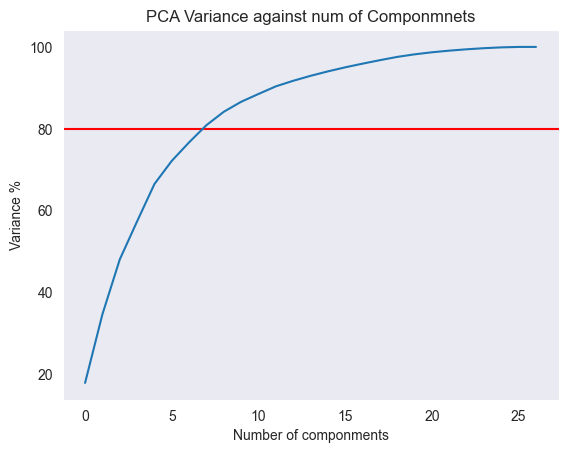

In [53]:
from sklearn.decomposition import PCA
pca = PCA()
df_train2= df_train.copy()
pca.fit(df_train2)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against num of Componmnets")
plt.ylabel("Variance %")
plt.xlabel("Number of componments")
l = plt.axhline(80, color="red")

plt.plot(var1)
plt.grid()

In [54]:
pca = PCA(n_components=7)
pca_train=pca.fit_transform(df_train2)
pca_train

array([[ 1.29821797, -0.08811703,  0.83152346, ...,  0.16757776,
         0.08423775, -0.24300699],
       [ 0.04936092, -0.65966806,  0.95247136, ...,  0.2469978 ,
         0.05141531,  0.01350605],
       [-0.74204213,  0.44664549,  0.46276508, ..., -0.56579672,
        -0.06592356,  0.35676608],
       ...,
       [-0.72844361,  0.49108543, -0.4718801 , ..., -0.62626761,
        -0.14957769,  0.20244692],
       [ 1.31019329, -0.00872515, -0.49957815, ...,  0.078213  ,
        -0.0486007 , -0.33804818],
       [ 1.27294672, -0.08476642,  1.07839189, ...,  0.16925869,
         0.05128437, -0.20263827]])

In [55]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.473975,0.434343,0.309746,0.849246,0.219450,0.562814,0.141206,0.618474,0.1250,0.769231,0.291667,0.538462,0.20,0.0,0.0,0.501191,0.421053,0.766810,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.221951,0.25
1,0.475463,0.747475,0.472630,0.924623,0.293370,0.462312,0.306533,0.184739,0.0625,0.384615,0.375000,0.923077,0.10,0.0,0.0,0.645900,0.543860,0.636624,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.321717,0.00
2,0.480477,0.858586,0.275701,0.095477,0.188265,0.914573,0.095477,0.112450,0.0625,0.384615,0.208333,0.538462,0.05,0.0,1.0,0.404077,0.789474,0.240343,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.324492,0.00
3,0.419647,0.252525,0.239653,0.000000,0.068145,0.020101,0.045226,0.056225,0.3125,0.615385,0.125000,0.615385,0.25,0.0,1.0,0.168993,0.438596,0.371960,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.112854,0.00
4,0.513018,0.646465,0.359813,0.282915,0.365558,0.164824,0.141206,0.297189,0.0000,0.307692,0.291667,0.615385,0.25,0.0,1.0,0.520055,0.596491,0.808298,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.222440,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.410274,0.666667,0.606809,0.065327,0.231578,0.065327,0.000000,0.160643,0.0625,0.461538,0.250000,0.846154,0.10,0.0,1.0,0.470775,0.192982,0.290415,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.350894,0.00
6996,0.457091,0.080808,0.391856,0.256281,0.518596,0.954774,0.000000,0.345382,0.0625,0.384615,0.291667,0.538462,0.10,0.0,1.0,0.728935,0.350877,0.937053,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281911,0.00
6997,0.227711,0.303030,0.036048,0.000000,0.005198,0.000000,0.000000,0.020080,0.1250,0.230769,0.041667,0.307692,0.30,0.0,1.0,0.019952,0.666667,0.280401,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.015245,0.00
6998,0.180200,0.080808,0.005340,0.030151,0.008085,0.030151,0.025126,0.068273,0.0625,0.230769,0.041667,0.230769,0.40,0.0,0.0,0.018960,0.280702,0.849785,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.007833,0.00


7 variaveis explicam ~80% da variancia

## Loading Scores for each PC

##  Correlação entre PC's e as variáveis originais

## Model Train

In [60]:
from sklearn.cluster import KMeans

kmeans= KMeans(n_clusters = 7, max_iter =10000, random_state= 1)
kmeans.fit(pca_train)
pca_train_label = kmeans.labels_

A:\FCUL\Pós-Graduação\DSML\DSML_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [61]:
kmeans2= KMeans(n_clusters = 7, max_iter = 10000, random_state = 1)
kmeans2.fit(df_train)
df_train_label = kmeans2.labels_

A:\FCUL\Pós-Graduação\DSML\DSML_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
dfTF= pd.DataFrame()
dfTF['Compare'] = pca_train_label== df_train_label
#pd.DataFrame(dfTF.groupby('Compare'))
dfTF.groupby(['Compare']).size().reset_index(name='counts') #TODO perguntar sobre pca e nao pca dar modelos iguais

,Compare,counts
0,False,6932
1,True,68


### 3.2.2. Misclassifications

### 3.2.3. Incoherencies

> 3.2.3.1 Clients that spent money but never had a registered Purchase

In [59]:
df[(df[['MntMeat&Fish', 'MntEntries',
       'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
       'MntAdditionalRequests']].sum(axis = 1) >= 0) & (df[['NumOfferPurchases', 'NumAppPurchases',
       'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)].shape

(26, 37)

### 3.2.4. Binning

### 3.2.5. Reclassification

### 3.2.6. Power Transform

## 3.3. Data Reduction

### 3.3.1. Multicollinearity - Check correlation

### 3.3.2. Unary Variables

### 3.3.3. Variables with a high percentage of missing values

## 3.2. Back to Data Transformation

### 3.2.7. Apply ordinal encoding and create Dummy variables

### 3.2.8. Scaling